## Assignment #4

* Release date: 2021/11/16 Tue
* Due date: **2021/11/23 Tue 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 10% (total 100 pts)

* Sentiment classification model using IMDB dataset
  * Compare LSTM and GRU models with **pretrained embedding from Glove**
  * You can download Glove model from the below link.
    * https://drive.google.com/open?id=1NgMR-bnt02gYTr44BVTo2fRePastYypW

> ### Prepare the dataset


In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17473536/17464789 [==============================] - 0s 0us/step


In [2]:
# construct embedding matrix from pretrained Glove model
import numpy as np
import os
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive' , force_remount=False)

word_index = imdb.get_word_index()

base_dir =  Path('/content/drive/My Drive/assignment4_16102284')
os.chdir(base_dir)
print(f"Current directory location: {os.getcwd()}")

embeddings_index = {}
f = open(os.path.join('data', 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(x_train.shape)
print(y_train.shape)
# preparing the GloVe word-embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))

for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_features:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Mounted at /content/drive
1654784/1641221 [==============================] - 0s 0us/step
Current directory location: /content/drive/My Drive/assignment4_16102284
Found 400000 word vectors.
(25000, 500)
(25000,)


> ### (30pts) Train LSTM model

* Try to find the optimal network architecture that contains LSTM layer.
  * Use **pretrained embedding from Glove** and **freeze** it during training.
  * You can design the architecture whatever you want.
  * However, the validation accuracy of the model should exceed 75%. 
  * Use randomly selected 20% of training dataset as validation dataset.
* Plot training/validation loss curve and training/validation accuracy curve.

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

current_path = Path().absolute()
checkpoint_path = current_path  / 'cp/lstm_glove_model_{epoch:02d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                              patience=5)   
def create_model():
  model = Sequential()
  model.add(Embedding(max_features, 100))
  model.add(LSTM(32))
  model.add(Dense(16))
  model.add(Dense(1, activation='sigmoid'))
  model.layers[0].set_weights([embedding_matrix])
  model.layers[0].trainable = False

  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
  
  
  return model

model = create_model() 
model.summary()

for var in model.trainable_variables:
    print(var.name)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,017,569
Trainable params: 17,569
Non-trainable params: 1,000,000
_________________________________________________________________
lstm/lstm_cell/kernel:0
lstm/lstm_cell/recurrent_kernel:0
lstm/lstm_cell/bias:0
dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0


In [4]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[cp_callback, earlystopping])

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.6832 - acc: 0.5551
Epoch 00001: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_01.ckpt
157/157 [==============================] - 58s 358ms/step - loss: 0.6832 - acc: 0.5551 - val_loss: 0.6667 - val_acc: 0.5938
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.6446 - acc: 0.6266
Epoch 00002: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_02.ckpt
157/157 [==============================] - 56s 358ms/step - loss: 0.6446 - acc: 0.6266 - val_loss: 0.6428 - val_acc: 0.6344
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.6137 - acc: 0.6632
Epoch 00003: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_03.ckpt
157/157 [==============================] - 56s 360ms/step - loss: 0.6137 - acc: 0.6632 - val_loss: 0.5985 - val_acc: 0.6698
Epoch 4/20
157/157 [=============================

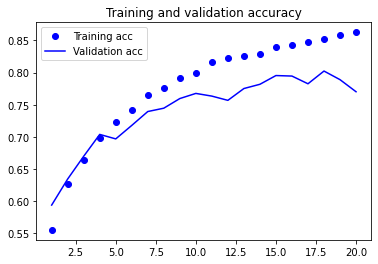

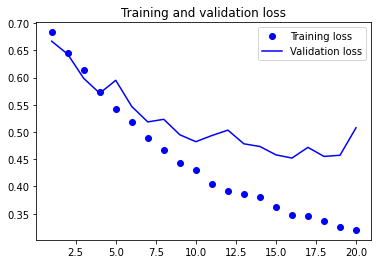

In [5]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* With the selected architecture, compute the final performance on test dataset.

In [6]:
latest_lstm = tf.train.latest_checkpoint(os.path.dirname(checkpoint_path))

final_model = create_model()
final_model.load_weights(latest_lstm)
final_model.evaluate(x_test, y_test)

782/782 [==============================] - 38s 47ms/step - loss: 0.5020 - acc: 0.7715


[0.501983106136322, 0.7714800238609314]

> ### (30pts) Train GRU model

* Again, try to find the optimal network architecture that contains GRU layer.
  * Use **pretrained embedding from Glove** and **freeze** it during training.
  * You can design the architecture whatever you want.
  * However, the validation accuracy of the model should exceed 75%. 
  * Use randomly selected 20% of training dataset as validation dataset.
* Plot training/validation loss curve and training/validation accuracy curve.

In [7]:
from keras.layers import GRU

checkpoint_path = current_path  / 'cp/gru_glove_model_{epoch:02d}.ckpt'

def create_model2():
  model = Sequential()
  model.add(Embedding(max_features, 100))
  model.add(GRU(32))
  model.add(Dense(16))
  model.add(Dense(1, activation='sigmoid'))
  model.layers[0].set_weights([embedding_matrix])
  model.layers[0].trainable = False  

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
  
  return model

model2 = create_model2()
model2.summary()
for var in model2.trainable_variables:
    print(var.name)





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,013,409
Trainable params: 13,409
Non-trainable params: 1,000,000
_________________________________________________________________
gru/gru_cell/kernel:0
gru/gru_cell/recurrent_kernel:0
gru/gru_cell/bias:0
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [8]:
history2 = model2.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[cp_callback, earlystopping])

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.6882 - acc: 0.5365
Epoch 00001: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_01.ckpt
157/157 [==============================] - 57s 346ms/step - loss: 0.6882 - acc: 0.5365 - val_loss: 0.6777 - val_acc: 0.5662
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.6572 - acc: 0.6019
Epoch 00002: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_02.ckpt
157/157 [==============================] - 54s 346ms/step - loss: 0.6572 - acc: 0.6019 - val_loss: 0.6380 - val_acc: 0.6292
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.6197 - acc: 0.6489
Epoch 00003: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_03.ckpt
157/157 [==============================] - 54s 343ms/step - loss: 0.6197 - acc: 0.6489 - val_loss: 0.6093 - val_acc: 0.6714
Epoch 4/20
157/157 [=============================

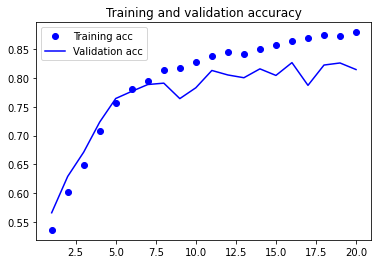

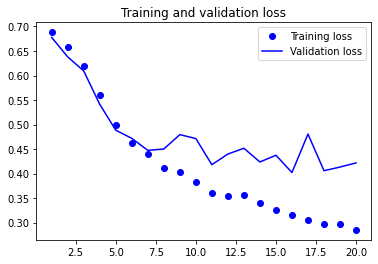

In [9]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* With the selected architecture, compute the final performance on test dataset.

In [10]:
latest_gru = tf.train.latest_checkpoint(os.path.dirname(checkpoint_path))

final_model2 = create_model2()
final_model2.load_weights(latest_gru)
final_model2.evaluate(x_test, y_test)

782/782 [==============================] - 33s 41ms/step - loss: 0.4160 - acc: 0.8143


[0.41601258516311646, 0.8143200278282166]

> ### (40pts) Training the model without pretrained embeddings, and compare it with the above models

* (10pts) Training the model (choose one of your previous models, LSTM or GRU) with randomly initialized and trainable embeddings.
  * This model should have exactly the same configuration as your previous model.
* (10pts) Plot training/validation loss curve and training/validation accuracy curve.
* (20pts) Compare the performance with the model based on pretrained embeddings and discuss the effect of such pretrained embeddings in this case.

In [11]:
checkpoint_path = current_path  / 'cp/unpretrained_glove_model_{epoch:02d}.ckpt'

def create_model3():
  model = Sequential()
  model.add(Embedding(max_features, 100))
  model.add(GRU(32))
  model.add(Dense(16))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
  
  return model

model3 = create_model3()
model3.summary()
for var in model3.trainable_variables:
    print(var.name)





Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         1000000   
                                                                 
 gru_2 (GRU)                 (None, 32)                12864     
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,013,409
Trainable params: 1,013,409
Non-trainable params: 0
_________________________________________________________________
embedding_4/embeddings:0
gru_2/gru_cell_2/kernel:0
gru_2/gru_cell_2/recurrent_kernel:0
gru_2/gru_cell_2/bias:0
dense_8/kernel:0
dense_8/bias:0
dense_9/kernel:0
dense_9/bias:0


In [12]:
history3 = model3.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[cp_callback, earlystopping])

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.4811 - acc: 0.7530
Epoch 00001: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_01.ckpt
157/157 [==============================] - 69s 429ms/step - loss: 0.4811 - acc: 0.7530 - val_loss: 0.3162 - val_acc: 0.8684
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.2362 - acc: 0.9083
Epoch 00002: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_02.ckpt
157/157 [==============================] - 67s 428ms/step - loss: 0.2362 - acc: 0.9083 - val_loss: 0.3109 - val_acc: 0.8796
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.1701 - acc: 0.9377
Epoch 00003: saving model to /content/drive/My Drive/assignment4_16102284/cp/lstm_glove_model_03.ckpt
157/157 [==============================] - 67s 428ms/step - loss: 0.1701 - acc: 0.9377 - val_loss: 0.3827 - val_acc: 0.8768
Epoch 4/20
157/157 [=============================

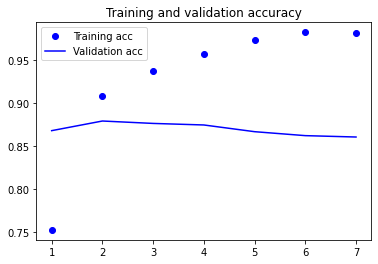

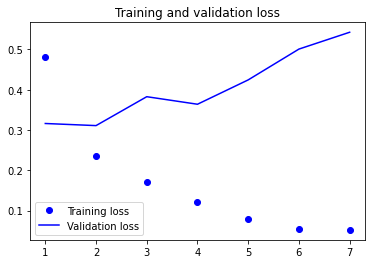

In [13]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
latest_nopretrained = tf.train.latest_checkpoint(os.path.dirname(checkpoint_path))

final_model3 = create_model2()
final_model3.load_weights(latest_nopretrained)
final_model3.evaluate(x_test, y_test)

782/782 [==============================] - 34s 43ms/step - loss: 0.5823 - acc: 0.8523


[0.5822928547859192, 0.8523200154304504]

##Compare the performance with the model based on pretrained embeddings and discuss the effect of such pretrained embeddings in this case.

<br>

Answer : The performance is a little better than the previous model, but overfitting occurs faster.